In [2]:
# We need to join the upper directory in order to access the local modules
import os
import pickle
import itertools
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pytdoa import nonlinoptim, linoptim, brutefoptim  # noqa: E402
from pytdoa.geodesy import SPEED_OF_LIGHT  # noqa: E402
from pytdoa.helpers import moving_average  # noqa: E402

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams["font.family"] = "Linux Libertine O"
plt.rcParams["font.size"] = 20

In [5]:
# Reading the mat files
with open("comnets_data/gnbPositions.json") as gnb_file:
    data = json.load(gnb_file)

gNBs = np.array([data["gnb0"], data["gnb1"], data["gnb2"], data["gnb3"]])
center = gNBs[3,:]
Rba = np.array([[np.cos(np.pi/2),-np.sin(np.pi/2),center[0]],[np.sin(np.pi/2),np.cos(np.pi/2),center[1]],[0.0,0.0,1.0]])
Rab = np.linalg.inv(Rba)

ggs = np.hstack((gNBs,np.ones((4,1))))
gNBs = np.matmul(Rab,ggs.T).T
gNBs = gNBs[:,0:2]

with open("comnets_data/uePositions.json") as ue_file:
    data = json.load(ue_file)

UEs = np.array(
    [data["ue0"], data["ue1"], data["ue2"], data["ue3"], data["ue4"], data["ue5"]]
)

uus = np.hstack((UEs,np.ones((6,1))))

UEs = np.matmul(Rab,uus.T).T
UEs = UEs[:,0:2]

## Playing a bit with the observed TDOA values

In [34]:
# Main params
POSITION = 4
FREQUENCY_MHZ = 100  # MHz
FREQUENCY = FREQUENCY_MHZ * 1e6
OVS = 4

# Reading and filtering
toa_measurements = pd.read_csv(
    f"comnets_data/oversampling/os{OVS}/exp{POSITION}_{FREQUENCY_MHZ}mhz.csv"
)
toa_measurements.drop(
    [
        "Unnamed: 0",
    ],
    axis=1,
    inplace=True,
)

if FREQUENCY_MHZ == 100:
    toa_filt = toa_measurements.loc[~((toa_measurements == float("-inf")).any(axis=1))]
    toa_filt.reset_index(drop=True, inplace=True)

elif FREQUENCY_MHZ == 40:
    toa_measurements = toa_measurements.drop(["gNB0", "P0"], axis=1)
    toa_filt = toa_measurements.loc[~((toa_measurements == float("-inf")).any(axis=1))]
    toa_filt.reset_index(drop=True, inplace=True)

else:
    raise RuntimeError("Not a supported frequency")
toa_filt.shape

(431, 8)

In [35]:
# Calculating the theoretical values
th_toa = np.linalg.norm(UEs[POSITION] - gNBs, axis=1)
th_tdoa = (th_toa.reshape((-1, 1)) - th_toa)[np.triu_indices(4, k=1)]
th_tdoa

array([ 0.47527784,  9.15963766,  7.43049195,  8.68435983,  6.95521411,
       -1.72914572])

In [36]:
# Moving Average parameters
ma_window = 10

# Vectorized version to obtain TDOA values
if FREQUENCY_MHZ == 100:
    toas = toa_filt[["gNB0", "gNB1", "gNB2", "gNB3"]].to_numpy()
    triu_indices = np.triu_indices(4, k=1)
else:
    toas = toa_filt[["gNB1", "gNB2", "gNB3"]].to_numpy()
    triu_indices = np.triu_indices(3, k=1)
tdoas = (
    toas.reshape((toas.shape[0], toas.shape[1], 1))
    - toas.reshape((toas.shape[0], 1, toas.shape[1]))
)[:, triu_indices[0], triu_indices[1]]

# A bit of masking to remove obvious outliers
maskl, masku = (tdoas > -20), tdoas < 20
mask = (maskl & masku).all(axis=1)
tdoas = moving_average(tdoas[mask, :], ma_window)

tdoas = tdoas / FREQUENCY / float(OVS) * SPEED_OF_LIGHT 
tdoa_mean = np.mean(tdoas, axis=0)

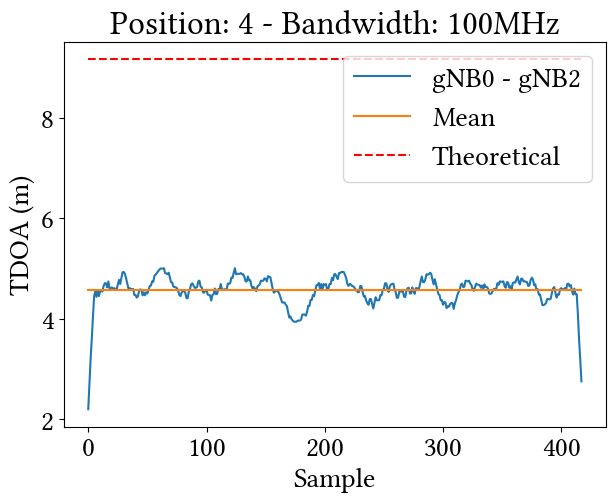

In [37]:
difference = 1
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(tdoas[:, difference])
ax.plot(tdoa_mean[difference] * np.ones(tdoas.shape[0]))
ax.plot(th_tdoa[difference] * np.ones(tdoas.shape[0]), linestyle="dashed", color="red")

ax.set_title(f"Position: {POSITION} - Bandwidth: {FREQUENCY_MHZ}MHz")
ax.set_xlabel("Sample")
ax.set_ylabel("TDOA (m)")
ax.legend(
    [
        f"gNB{triu_indices[0][difference]} - gNB{triu_indices[1][difference]}",
        "Mean",
        "Theoretical",
    ]
)

In [53]:
experiment = 1
combination_range = itertools.combinations(np.arange(len(gNBs)), 2)
combinations = np.fromiter(combination_range, dtype=np.dtype((int,2)))

linpos = linoptim(gNBs,tdoas[experiment,0:4],input_type='xyz').squeeze()
print(f"Calculated Position - x: {linpos[0]:.4f} y: {linpos[1]:.4f}")

off = False
result = nonlinoptim(gNBs, tdoas[experiment,:], combinations, num_dim=2, p0=np.array([0.0,0.0]), input_type="xyz", use_offset=off, l=.5)
print(f"Calculated Position - x: {result[0]:.4f} y: {result[1]:.4f}")

result = brutefoptim(gNBs, tdoas[experiment,:], combinations, num_dim=2, input_type="xyz")
print(f"Calculated Position - x: {result[0]:.4f} y: {result[1]:.4f}")

print(f"Real Position - x: {UEs[POSITION,0]:.4f} y: {UEs[POSITION,1]:.4f}")

Calculated Position - x: -0.7988 y: 2.5056
Calculated Position - x: 2.9750 y: 3.9427
Calculated Position - x: 2.9751 y: 3.9427


NameError: name 'POSITION' is not defined

In [39]:
# Let's do some specific processing
o = np.zeros(4)
for i in range(tdoas.shape[0]):
    result = nonlinoptim(gNBs, tdoas[experiment,:], combinations, num_dim=2, p0=linpos, input_type="xyz", use_offset=True, l=.5)
    o += result[2:]

o /= tdoas.shape[0]

In [40]:
do = (o.reshape((-1, 1)) - o.reshape(1, -1))[triu_indices[0], triu_indices[1]]
tdoas_corrected = tdoas - do
tdoas_corrected_mean = np.mean(tdoas_corrected, axis=0)

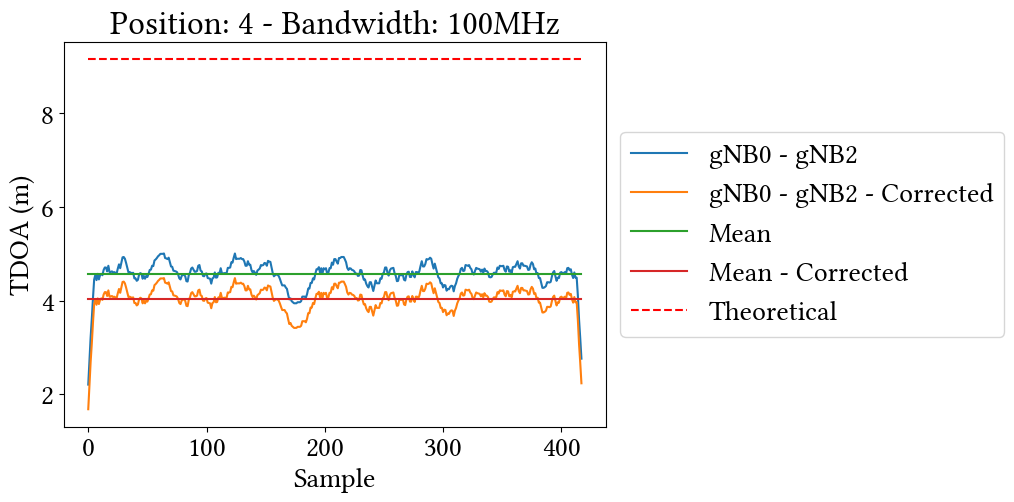

In [41]:
difference = 1
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(tdoas[:, difference])
ax.plot(tdoas_corrected[:, difference])
ax.plot(tdoa_mean[difference] * np.ones(tdoas.shape[0]))
ax.plot(tdoas_corrected_mean[difference] * np.ones(tdoas_corrected.shape[0]))
ax.plot(th_tdoa[difference] * np.ones(tdoas_corrected.shape[0]), linestyle="dashed", color="red")

ax.set_title(f"Position: {POSITION} - Bandwidth: {FREQUENCY_MHZ}MHz")
ax.set_xlabel("Sample")
ax.set_ylabel("TDOA (m)")
ax.legend(
    [
        f"gNB{triu_indices[0][difference]} - gNB{triu_indices[1][difference]}",
        f"gNB{triu_indices[0][difference]} - gNB{triu_indices[1][difference]} - Corrected",
        "Mean",
        "Mean - Corrected",
        "Theoretical",
    ],
    loc="center left", 
    bbox_to_anchor=(1, 0.5),
)

plt.show()

## Let's get TDOA offsets for all positions

In [7]:
# Let's analyze one frequency at a time
frequency_mhz = 100  # MHz
frequency = [122.88e6 if frequency_mhz == 100 else 61.44e6]
ma_window = 10

result_dict = {}

result_dict["ma"] = ma_window
result_dict["frequency"] = frequency
result_dict["frequency_mhz"] = frequency_mhz
for os in [1,2,4]:
    for position in [0,4]:
        # Reading and filtering
        df = pd.read_csv(f"comnets_data/oversampling/os{os}/exp{position}_{frequency_mhz}mhz.csv")
        df.drop(
            [
                "Unnamed: 0",
            ],
            axis=1,
            inplace=True,
        )

        # Setting the stage
        n = 4  # We will use 4 gNBs except for position 4

        # This is internal knowledge
        if frequency_mhz == 100:
            df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
            df_filt.reset_index(drop=True, inplace=True)

        elif frequency_mhz == 40:
            df.drop(["gNB0", "P0"], axis=1, inplace=True)

            df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
            df_filt.reset_index(drop=True, inplace=True)
        
        else:
            raise RuntimeError("Unsupported frequency")

        # Calculating the theoretical values
        th_toa = np.linalg.norm(UEs[position] - gNBs, axis=1)
        th_tdoa = (th_toa.reshape((-1, 1)) - th_toa)[np.triu_indices(n, k=1)]
        result_dict[f"P{position}", "th_tdoa"] = th_tdoa

        triu_indices = np.triu_indices(n, k=1)
        tdoas = (
            toas.reshape((toas.shape[0], toas.shape[1], 1))
            - toas.reshape((toas.shape[0], 1, toas.shape[1]))
        )[:, triu_indices[0], triu_indices[1]]

        # A bit of masking to remove obvious outliers
        maskl, masku = (tdoas > -30), tdoas < 30
        mask = (maskl & masku).all(axis=1)
        tdoas = moving_average(tdoas[mask, :], ma_window)

        tdoas = tdoas / frequency * SPEED_OF_LIGHT / float(os)
        tdoas_mean = np.mean(tdoas, axis=0)

        # Let's store our precious data
        result_dict[f"os{os}",f"P{position}", "tdoas"] = tdoas
        result_dict[f"os{os}",f"P{position}", "tdoas_mean"] = tdoas_mean

NameError: name 'toas' is not defined

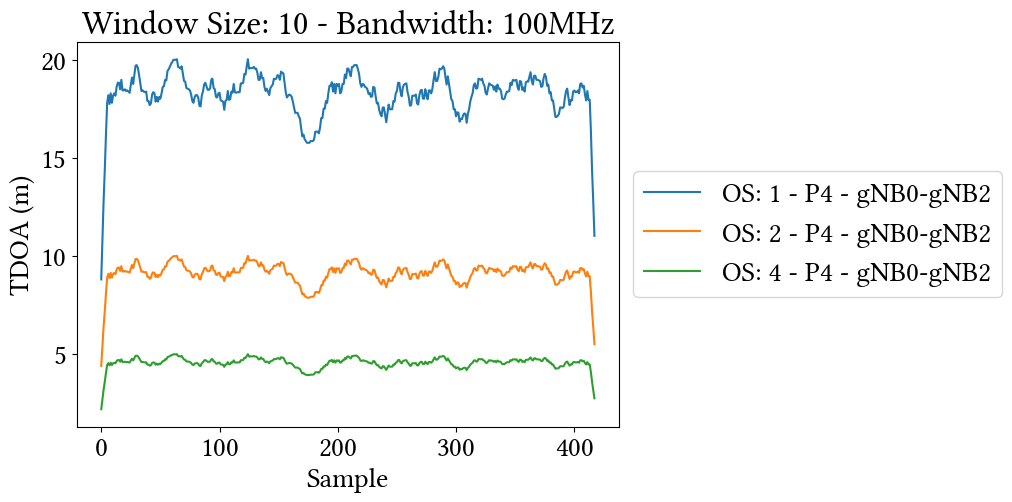

In [58]:
difference = 1

fig, ax = plt.subplots(figsize=(7, 5))

p = 4
for i in [1,2,4]:
    if i == 4 and difference > 2:
        continue
    td = result_dict[f"os{i}",f"P{p}", "tdoas"]
    ax.plot(
        td[:, difference],
        label=f"OS: {i} - P{p} - gNB{triu_indices[0][difference]}-gNB{triu_indices[1][difference]}",
    )

ax.set_title(f'Window Size: {result_dict["ma"]} - Bandwidth: {frequency_mhz}MHz')
ax.set_xlabel("Sample")
ax.set_ylabel("TDOA (m)")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

## Positioning results for all positions

In [6]:
# Let's analyze one frequency at a time
frequency_mhz = 100  # MHz
frequency = [122.88e6 if frequency_mhz == 100 else 61.44e6]
ma_window = 50
ngnb = 4
s = 1.0
samples = 300

result_dict = {}

result_dict["ma"] = ma_window
result_dict["frequency"] = frequency
result_dict["frequency_mhz"] = frequency_mhz
n = 4  # We will use 4 gNBs except for position 4 & 40 MHz examples
for os in [1,2,4]:
    for position in [0,4,5]:
        if os == 4 and position == 5:
            continue
        # Reading and filtering
        df = pd.read_csv(f"comnets_data/oversampling/os{os}/exp{position}_{frequency_mhz}mhz.csv")
        df.drop(
            [
                "Unnamed: 0",
            ],
            axis=1,
            inplace=True,
        )

        # This is internal knowledge
        if frequency_mhz == 100:
            df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
            df_filt.reset_index(drop=True, inplace=True)
            gnbs = gNBs

        elif frequency_mhz == 40:
            n = 3
            df.drop(["gNB0", "P0"], axis=1, inplace=True)
            gnbs = gNBs[1:, :]

            df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
            df_filt.reset_index(drop=True, inplace=True)

        else:
            raise RuntimeError("Unsupported frequency")

        # Calculating the theoretical values
        th_toa = np.linalg.norm(UEs[position] - gnbs, axis=1)
        th_tdoa = (th_toa.reshape((-1, 1)) - th_toa)[np.triu_indices(n, k=1)]
        result_dict[f"P{position}", "th_tdoa"] = th_tdoa

        # Vectorized version to obtain TDOA values
        if frequency_mhz == 100:
            toas = df_filt[["gNB0", "gNB1", "gNB2", "gNB3"]].to_numpy()
        elif frequency_mhz == 40:
            toas = df_filt[["gNB1", "gNB2", "gNB3"]].to_numpy()
        else:
            raise RuntimeError("Unsupported frequency")

        triu_indices = np.triu_indices(n, k=1)
        tdoas = (
            toas.reshape((toas.shape[0], toas.shape[1], 1))
            - toas.reshape((toas.shape[0], 1, toas.shape[1]))
        )[:, triu_indices[0], triu_indices[1]]

        # A bit of masking to remove obvious outliers
        maskl, masku = (tdoas > -7*os), tdoas < 7*os
        mask = (maskl & masku).all(axis=1)
        tdoas = moving_average(tdoas[mask, :], ma_window)

        if tdoas.shape[0] > samples:
            vals = np.random.choice(tdoas.shape[0],samples, replace=False)
            tdoas = tdoas[vals,:]

        tdoas = tdoas / frequency * SPEED_OF_LIGHT / os 
        tdoas_mean = np.mean(tdoas, axis=0)

        # Let's start the positioning routines
        combination_range = itertools.combinations(np.arange(len(gnbs)), 2)
        combinations = np.fromiter(combination_range, dtype=np.dtype((int, 2)))

        result_dict[f'os{os}',f'P{position}','offsets'] = tdoas - th_tdoa

        r = list(range(0,tdoas.shape[1]))
        if position == 4:
            if os == 2 or os == 4:
                r = [0,5]

        linear = []
        nonlin = []
        for experiment in range(len(tdoas)):
            linpos = linoptim(gNBs, tdoas[experiment, 0:n], input_type="xyz").squeeze()
            result = nonlinoptim(
                gNBs,
                tdoas[experiment, r],
                combinations[r,:],
                num_dim=2,
                p0=linpos,
                input_type="xyz",
                search_size=s,
            )

            linear.append(linpos)
            nonlin.append(result)
        
        result_dict[f'os{os}',f'P{position}','linear'] = np.array(linear)
        result_dict[f'os{os}',f'P{position}','nonlin'] = np.array(nonlin)

        print(f"Finished P{position} - Processed {len(tdoas)} points.")

filename = f'comnets_data/results/oversampling/{n}_{frequency_mhz}mhz_window_{ma_window}_s_{int(s)}.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Results saved to: {filename}")

TypeError: nonlinoptim() got an unexpected keyword argument 's'

## Processing the results

In [7]:
frequency_mhz = 100

with open('comnets_data/results/oversampling/4_100mhz_window_20_s_1.pickle', 'rb') as p:
    data_no_offset = pickle.load(p)

In [8]:
eelin_d = {}
eenli_d = {}
for os in [1,2,4]:
    eelin = np.array([])
    eenli = np.array([])
    eebrt = np.array([])        
    for i in [0,4,5]:
        if os == 4 and i == 5:
            continue
        ue = UEs[i]
        lin = data_no_offset[f'os{os}',f'P{i}','linear']
        nli = data_no_offset[f'os{os}',f'P{i}','nonlin'][:,0:2]
        # nlim = np.mean(nli,axis=0)
        # nli = nli + (ue - nlim)

        elin = np.linalg.norm(ue-lin,axis=1)
        enli = np.linalg.norm(ue-nli,axis=1)

        eelin = np.append(eelin, elin)
        eenli = np.append(eenli, enli)


    
    eelin = eelin[eenli < 1000]
    print(f'Before filter: {eenli.shape[0]}')
    eenli = eenli[eenli < 1000]
    print(f'After filter: {eenli.shape[0]}')
    eelin_d[os] = eelin
    eenli_d[os] = eenli


Before filter: 895
After filter: 895
Before filter: 739
After filter: 739
Before filter: 408
After filter: 408


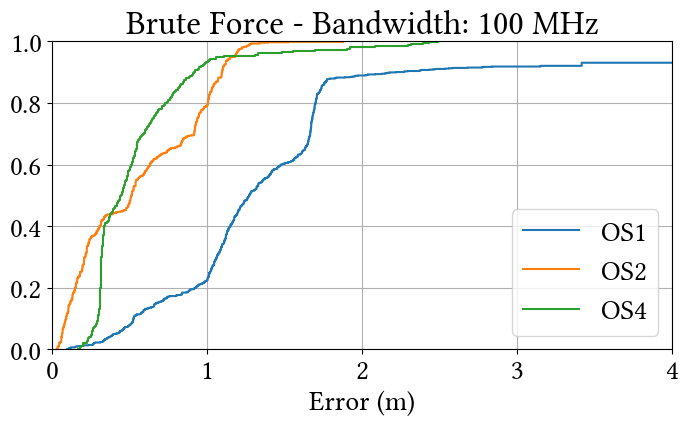

In [39]:
f, ax = plt.subplots(figsize=(8, 4))

ax.ecdf(eenli_d[1])
ax.ecdf(eenli_d[2])
ax.ecdf(eenli_d[4])

ax.set_xlim([0,4])
ax.grid()

ax.set_title(f'Brute Force - Bandwidth: {frequency_mhz} MHz')
ax.set_xlabel('Error (m)')
ax.legend(['OS1', 'OS2', 'OS4'])

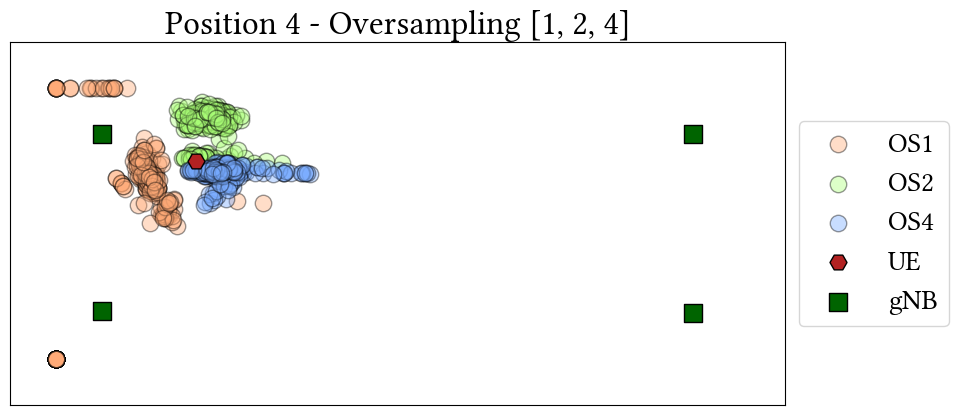

In [10]:
pos, ovsm = 4,[1,2,4]
fig, ax = plt.subplots(figsize=(10, 5))

col = {1: '#ffaa77', 2: '#aaff77', 4: '#77aaff'}

ax.set_xticks([])
ax.set_yticks([])

for os in ovsm:
    if os == 4 and pos == 5:
        continue
    pts = data_no_offset[f'os{os}',f'P{pos}','nonlin']
    nlim = np.mean(pts,axis=0)
    # pts = pts + (ue - nlim)

    ax.scatter(pts[:,0], pts[:,1], 140, col[os], 'o', alpha=.4, edgecolors='black',label=f'OS{os}')  

ax.scatter(UEs[pos,0],UEs[pos,1], 150, 'firebrick', 'H', edgecolors='black', label='UE')
ax.scatter(gNBs[:,0], gNBs[:,1], 180, 'darkgreen', 's', edgecolors='black', label='gNB')
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_xlim([np.min(gNBs[:,0])-2.0, np.max(gNBs[:,0])+2.0])
ax.set_ylim([np.min(gNBs[:,1])-2.0, np.max(gNBs[:,1])+2.0])

# ax.legend(('Results', 'UE', 'gNBs'), loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title(f'Position {pos} - Oversampling {ovsm}')

plt.gca().set_aspect('equal')
plt.show()

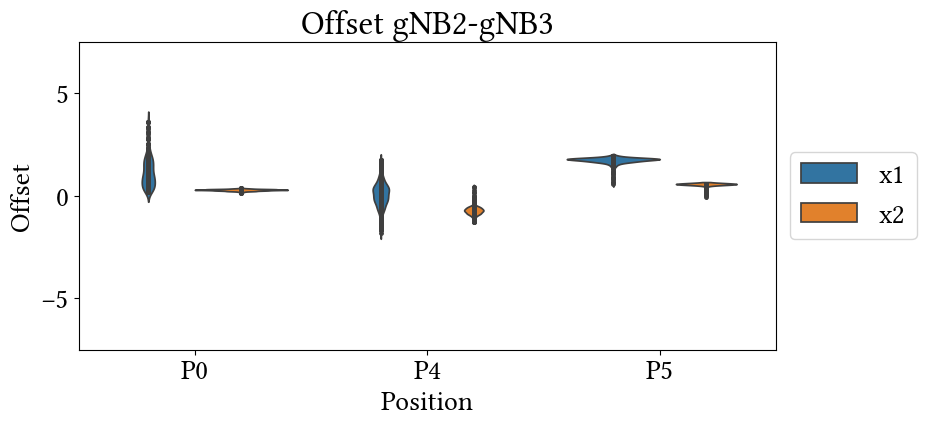

In [206]:
difference = 5
offsets = pd.DataFrame(columns=['Position','Offset','OS'])
for pos in [0,4,5]:
    for os in [1,2]:
        d = {}
        d['Offset'] = data_no_offset[f'os{os}',f'P{pos}','offsets'][:,difference]
        d['Position'] = np.repeat([f"P{pos}"],len(d['Offset']))
        d['OS'] = np.repeat([f"x{os}"],len(d['Offset']))
        df = pd.DataFrame.from_dict(d)
        if offsets.empty:
            offsets = df
        else:
            offsets = pd.concat((offsets,df),ignore_index=True)

fig, ax = plt.subplots(figsize=(9, 4))

ax.set_title(f'Offset gNB{triu_indices[0][difference]}-gNB{triu_indices[1][difference]}')
sns.violinplot(data=offsets, x='Position', y='Offset', hue='OS', ax=ax, inner="point")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_ylim([-7.5,7.5])
plt.show()